In [1]:
import os
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_metrics(results):
    
    metrics_dict={}

    for seed in results.keys():
        
        result_seed=results[seed]
        cpe_weights=list(result_seed.keys())
        # cpe_weights.remove("setting")

        _, n_post_samples=result_seed[cpe_weights[0]][0].shape

        
        metrics_dict[seed]={}
        
        metrics_dict[seed]["nll_gibbs_train"]=[]
        metrics_dict[seed]["nll_gibbs_test"]=[]
        metrics_dict[seed]["nll_bayes_train"]=[]
        metrics_dict[seed]["nll_bayes_test"]=[]
        
        metrics_dict[seed]["err_gibbs_train"]=[]
        metrics_dict[seed]["err_gibbs_test"]=[]
        metrics_dict[seed]["err_bayes_train"]=[]
        metrics_dict[seed]["err_bayes_test"]=[]

        # metrics_dict[seed]["grad_nll_gibbs"]=[]

        for cpe_weight in cpe_weights:
            
            log_p_train=torch.tensor(result_seed[cpe_weight][0])
            log_p_test=torch.tensor(result_seed[cpe_weight][1])
            
            metrics_dict[seed]["nll_gibbs_train"].append(-log_p_train.mean().item())
            metrics_dict[seed]["nll_gibbs_test"].append(-log_p_test.mean().item())
            
            bayes_loss_train=(torch.log(torch.tensor(n_post_samples)) - torch.logsumexp(log_p_train, 1)).mean().item()
            metrics_dict[seed]["nll_bayes_train"].append(bayes_loss_train)
            bayes_loss_test=(torch.log(torch.tensor(n_post_samples)) - torch.logsumexp(log_p_test, 1)).mean().item()
            metrics_dict[seed]["nll_bayes_test"].append(bayes_loss_test)
            
            # grad_expected_gibbs = (
            #         -n_train
            #         * (
            #             (log_p_train.mean(0) * log_p_test.mean(0)).mean()
            #             - log_p_test.mean() * log_p_train.mean()
            #         ).item()
            #     )
            # metrics_dict[seed]["grad_nll_gibbs"].append(grad_expected_gibbs)

            metrics_dict[seed]["err_gibbs_train"].append(1-np.array(result_seed[cpe_weight][2])[:,1].mean())
            metrics_dict[seed]["err_gibbs_test"].append(1-np.array(result_seed[cpe_weight][3])[:,1].mean())
            metrics_dict[seed]["err_bayes_train"].append(1-np.array(result_seed[cpe_weight][4])[:,1].mean())
            metrics_dict[seed]["err_bayes_test"].append(1-np.array(result_seed[cpe_weight][5])[:,1].mean())

    return metrics_dict

In [3]:
setting_i="prior_scale_0.1_label_noise_0.0_smooth_softmax_1.0_data_augmentation_False"

with open(f'{setting_i}.pickle', 'rb') as handle:
    results = pickle.load(handle)
metrics=get_metrics(results)
seeds=list(results.keys())
cpe_weights=list(results[seeds[0]].keys())
# cpe_weights.remove("setting")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# different effects

In [6]:
effect="label_noise"
effect_range=[0.0, 0.1, 0.3, 0.5]
dir_prefix = f"./between seeds/{effect}/"
if not os.path.exists(dir_prefix):
    os.makedirs(dir_prefix)

In [7]:
all_metrics={}
for effect_val in effect_range:
    if effect=="label_noise":
        setting_i=f"prior_1.0_label_{effect_val}_smooth_1.0_False_lambs_long_60000"
    if effect=="prior":
        setting_i=f"prior_{effect_val}_label_0.0_smooth_1.0_False_lambs_long_60000"
    if effect=="smooth":
        setting_i=f"prior_1.0_label_0.0_smooth_{effect_val}_False_lambs_long_60000"
    with open(f'{setting_i}.pickle', 'rb') as handle:
        results =pickle.load(handle)
        metrics=get_metrics(results)
        all_metrics[effect_val]=metrics

seeds=list(results.keys())
cpe_weights=list(results[seeds[0]].keys())

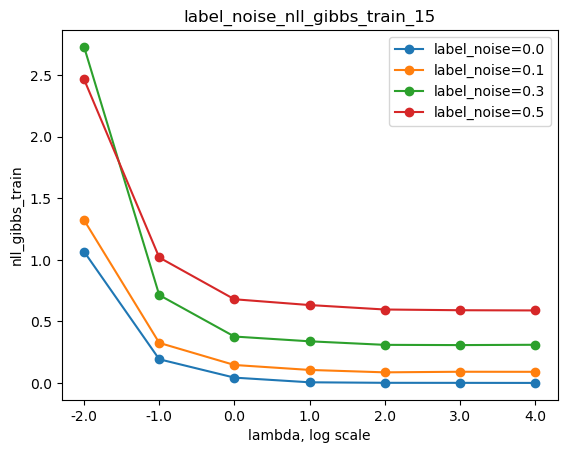

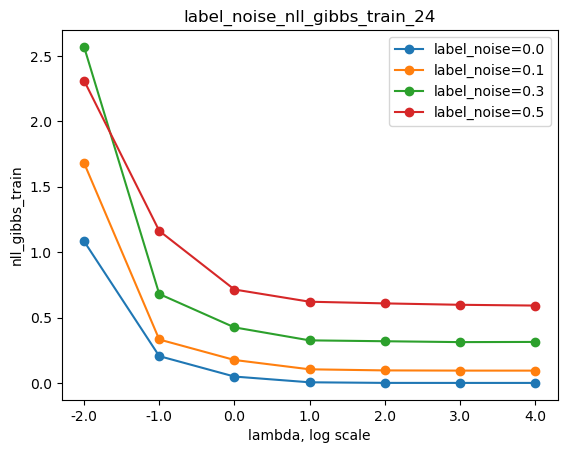

In [9]:
name_metrics=['nll_gibbs_train','nll_bayes_test']
for name_metric in name_metrics:
    for seed in seeds:
        save_name=f"{effect}_{name_metric}_{seed}"
        plt.figure()
        plt.title(save_name)
        for effect_val in effect_range:
            plt.plot(np.arange(0,len(cpe_weights),1),all_metrics[effect_val][seed][name_metric], marker="o", label=f"{effect}={effect_val}")
            plt.plot(np.arange(0,len(cpe_weights),1),all_metrics[effect_val][seed][name_metric], marker="o", label=f"{effect}={effect_val}")

        plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
        plt.legend()
        plt.xlabel("lambda, log scale")
        plt.ylabel(name_metric)
        # plt.ylim(0.02,0.06)
        plt.savefig(f"./{dir_prefix}/{save_name}.png", dpi=300)
        plt.show()

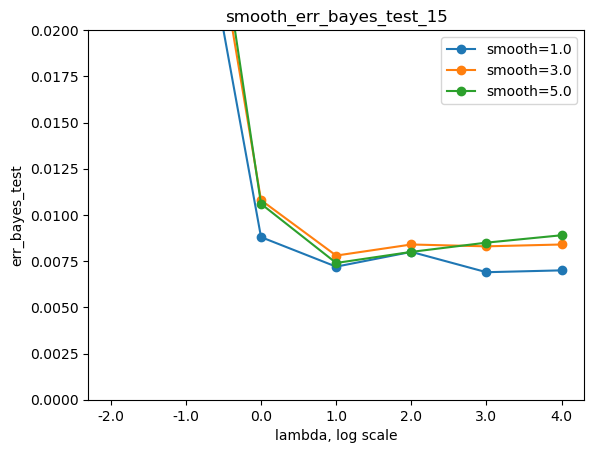

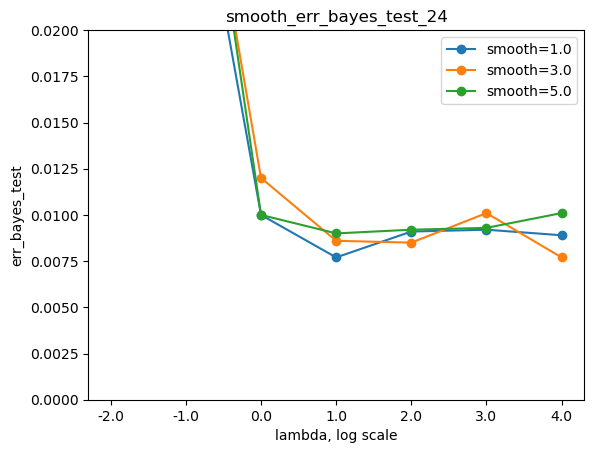

In [45]:
name_metrics=['err_bayes_test']
for name_metric in name_metrics:
    for seed in seeds:
        save_name=f"{effect}_{name_metric}_{seed}"
        plt.figure()
        plt.title(save_name)
        for effect_val in effect_range:
            plt.plot(np.arange(0,len(cpe_weights),1),all_metrics[effect_val][seed][name_metric], marker="o", label=f"{effect}={effect_val}")
        plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
        plt.legend()
        plt.xlabel("lambda, log scale")
        plt.ylabel(name_metric)
        plt.ylim(0,0.02)
        plt.savefig(f"./{dir_prefix}/{save_name}.png", dpi=300)
        plt.show()

In [94]:
setting_i="prior_scale_1.0_label_smoothing_0.0_smooth_softmax_3.0_data_augmentation_False_lambs_short"

with open(f'{setting_i}.pickle', 'rb') as handle:
    results = pickle.load(handle)
metrics=get_metrics(results)
seeds=list(results.keys())
cpe_weights=list(results[seeds[0]].keys())
# cpe_weights.remove("setting")

# in-between seeds

In [7]:
dir_prefix = f"./between seeds/{setting_i}/"
if not os.path.exists(dir_prefix):
    os.makedirs(dir_prefix)

In [11]:
# name_metrics=list(metrics[seeds[0]].keys())
# for name_metric in name_metrics:
#     save_name=f"{name_metric}"
#     plt.figure()
#     plt.title(save_name)
#     for seed in seeds:
#         plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][name_metric], marker="o", label=f"{seed}")

#     plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
#     plt.legend()
#     plt.xlabel("lambda, log scale")
#     plt.ylabel(name_metric)
#     plt.ylim(0,0.1)
#     # plt.savefig(f"./{dir_prefix}/{save_name}.png", dpi=300)
#     plt.show()

# main plots

In [4]:
setting_i="prior_scale_0.1_label_noise_0.0_smooth_softmax_1.0_data_augmentation_False"

with open(f'{setting_i}.pickle', 'rb') as handle:
    results = pickle.load(handle)
metrics=get_metrics(results)
seeds=list(results.keys())
cpe_weights=list(results[seeds[0]].keys())
# cpe_weights.remove("setting")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [6]:
results.keys()

dict_keys([15])

In [4]:
dir_prefix = f"./main/{setting_i}/"
if not os.path.exists(dir_prefix):
    os.makedirs(dir_prefix)

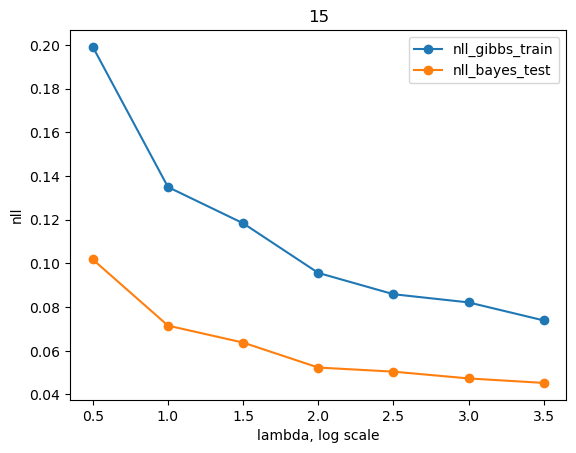

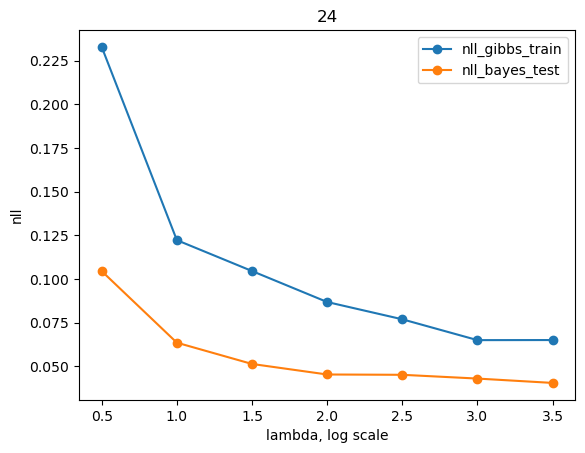

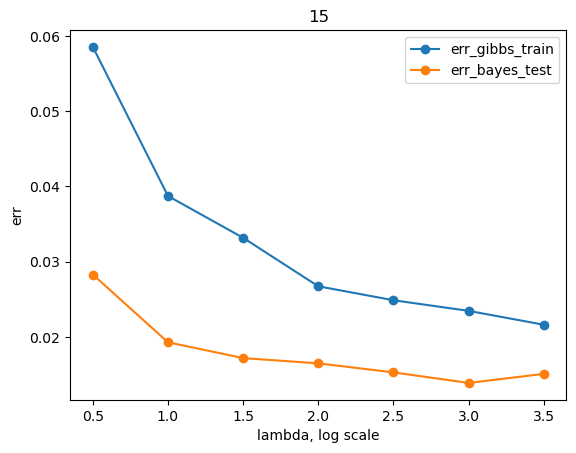

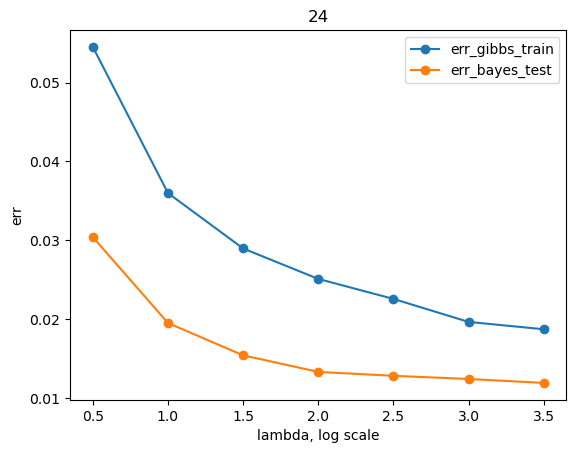

In [5]:
name_metrics=["nll","err"]
for metric in name_metrics:
    for seed in seeds:
        save_name=f"main_{metric}_{seed}"
        plt.title(f"{seed}")
        plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][f"{metric}_gibbs_train"], marker="o", label=f"{metric}_gibbs_train")
        plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][f"{metric}_bayes_test"], marker="o", label=f"{metric}_bayes_test")
        # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
        plt.xticks(np.arange(0,len(cpe_weights),1), cpe_weights)
        plt.xlabel("lambda, log scale")
        plt.ylabel(f"{metric}")
        # plt.ylim(0,0.5)
        plt.legend()
        plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
        plt.show()